In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),
            
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            
            nn.Linear(256,2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2



net = SiameseNetwork()
net.load_state_dict(torch.load(r"C:\Users\ercih\Desktop\aspava-yildiz\model.pb"))

<All keys matched successfully>

In [11]:
import cv2
from PIL import Image
import torch.nn.functional as F
import os


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)


      return euclidean_distance

loss = ContrastiveLoss()
ds = r"C:\Users\ercih\Desktop\aspava-yildiz\python\images_data\siamese_256"
f1 = r"C:\Users\ercih\Desktop\aspava-yildiz\python\images_data\siamese_256\n1_1\n1_1_2_gt.png"
f2 = r"C:\Users\ercih\Desktop\aspava-yildiz\python\images_data\siamese_256\n2_1\n2_1_1_vertical.png"

import random

onlyfolders = [f for f in os.listdir(ds) if os.path.isdir(os.path.join(ds, f))]
t = random.randint(0,1)
two_classes = random.sample(onlyfolders, 2)
print(ds,two_classes)

if t == 0:
    print("t=0")
    onlyfiles_1 = [f for f in os.listdir(os.path.join(ds,two_classes[0])) if os.path.isfile(os.path.join(ds,two_classes[0], f))]
    onlyfiles_2 = [f for f in os.listdir(os.path.join(ds,two_classes[1])) if os.path.isfile(os.path.join(ds,two_classes[1], f))]
    f1 = os.path.join(ds,two_classes[0], random.sample(onlyfiles_1, 1)[0])
    f2 = os.path.join(ds,two_classes[1], random.sample(onlyfiles_2, 1)[0])

else:
    print("t=1")
    onlyfiles = [f for f in os.listdir(os.path.join(ds,two_classes[0])) if os.path.isfile(os.path.join(ds,two_classes[0], f))]
    print(onlyfiles)
    samples = random.sample(onlyfiles,2)
    f1 = os.path.join(ds,two_classes[0], samples[0])
    f2 = os.path.join(ds,two_classes[0], samples[1])

def inference(f1, f2):
    img0_pil = Image.open(f1).convert("RGB")
    # img0_flipped_pil = Image.fromarray(cv2.flip(np.asarray(img0_pil), 0))
    img0_flipped_pil = Image.open(f2).convert("RGB")
    transformation = transforms.Compose([transforms.Resize((100,100)),
                                        transforms.ToTensor()
                                    ])
    img0 = transformation(img0_pil)
    img0_flipped = transformation(img0_flipped_pil)
    output1, output2 = net(torch.unsqueeze(img0, dim=0), torch.unsqueeze(img0_flipped, dim=0))
    dist = loss(output1, output2)
    return dist
inference(f1,f2)

C:\Users\ercih\Desktop\aspava-yildiz\python\images_data\siamese_256 ['n02087046_6522', 'n02087394_7644']
t=0


tensor([[7.0525]], grad_fn=<NormBackward1>)

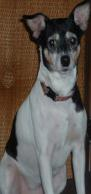

In [12]:
Image.open(f1).convert("RGB")

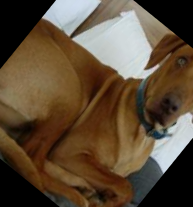

In [13]:
Image.open(f2).convert("RGB")